Simple gas turbine model

The gas turbine can be described as a combination of three Zustandsänderungen, compressor, combustion chamber, expander. A simple thermodynamic modell uses ideal gas equation or simple Stoffwertpolynome (KKH) to calculate the temperatures and enthalpies, see TDO.

Are sophisticated modell can be set up using TESPy and CoolProp library.

The flowchart depicts all components and given parameters. The net work rate of the process should be 150 MW.

The process can be calculated using TESPy.

In [2]:
from tespy.networks import Network
from tespy.components import (
    Sink, Source,
    Compressor,
    DiabaticCombustionChamber,
    Turbine
)
from tespy.connections import Connection, Bus

# general configurations
# substances, fluids, network, units
fluid_list = ['N2', 'O2', 'Ar', 'CO2', 'H2O', 'CH4']
gas_turbine = Network(fluids=fluid_list, p_unit='bar', T_unit='C', h_unit='kJ / kg')

# composition of given fluids
air = {'N2': 0.7551, 'O2': 0.2314, 'Ar': 0.0129, 'CO2': 0.0006, 'H2O': 0, 'CH4': 0}
fuel = {'N2': 0, 'O2': 0, 'Ar': 0, 'CO2': 0, 'H2O': 0, 'CH4': 1}

# define sources and sinks
src_air = Source('air')
src_fuel = Source('fuel')
snk_exhaust = Sink('exhaust')

# define components
cmp_AC = Compressor('air compressor')
cmp_CC = DiabaticCombustionChamber('combustion chamber')
cmp_EX = Turbine('expander')

# define connections
c1 = Connection(src_air, 'out1', cmp_AC, 'in1', label='1')
c2 = Connection(cmp_AC, 'out1', cmp_CC, 'in1', label='2')
c3 = Connection(src_fuel, 'out1', cmp_CC, 'in2', label='3')
c4 = Connection(cmp_CC, 'out1', cmp_EX, 'in1', label='4')
c5 = Connection(cmp_EX, 'out1', snk_exhaust, 'in1', label='5')

# add connections to network
gas_turbine.add_conns(c1, c2, c3, c4, c5)

# parameter of components
cmp_AC.set_attr(eta_s=0.85, pr=18)
cmp_CC.set_attr(eta=0.98, pr=0.95)
cmp_EX.set_attr(eta_s=0.9)

# parameter of connections
c1.set_attr(p=1.013, T=25, fluid=air)
c3.set_attr(p=20, T=25, fluid=fuel)
c4.set_attr(T=1400)
c5.set_attr(p=1.013)

# busses
work_net = Bus('work netto')
fuel_in = Bus('fuel input')

work_net.add_comps(
    {'comp': cmp_AC, 'base': 'bus', 'char': 1},
    {'comp': cmp_EX, 'char': 1})

fuel_in.add_comps(
    {'comp': cmp_CC, 'base': 'bus'}
)

gas_turbine.add_busses(work_net, fuel_in)

# parameter of busses
work_net.set_attr(P=-150e6)

# solve network
gas_turbine.solve('design')

# print network results
gas_turbine.print_results()

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 1.62e+08 | 3.44e+02 | 1.34e+06 | 4.41e+05 | 3.83e+01
2	| 1.87e+08 | 4.41e+02 | 7.29e-10 | 1.71e+05 | 2.30e-01
3	| 2.57e+08 | 1.30e+02 | 6.14e-10 | 2.03e+05 | 7.57e-02
4	| 2.81e+08 | 3.87e+01 | 4.39e-10 | 1.50e+05 | 2.50e-02
5	| 1.11e+07 | 4.88e+00 | 3.39e-10 | 5.32e+04 | 2.46e-03
6	| 7.81e+05 | 8.30e-01 | 3.20e-10 | 4.93e+03 | 1.92e-04
7	| 5.33e+04 | 4.76e-02 | 5.11e-10 | 3.78e+02 | 1.58e-05
8	| 4.24e+03 | 4.03e-03 | 5.10e-10 | 3.10e+01 | 1.34e-06
9	| 3.58e+02 | 3.41e-04 | 5.10e-10 | 2.63e+00 | 1.13e-07
10	| 3.03e+01 | 2.89e-05 | 5.10e-10 | 2.22e-01 | 9.58e-09
11	| 2.57e+00 | 2.44e-06 | 5.10e-10 | 1.88e-02 | 8.11e-10
12	| 2.18e-01 | 2.07e-07 | 5.10e-10 | 1.59e-03 | 6.87e-11
13	| 1.84e-02 | 1.75e-08 | 5.10e-10 | 1.35e-04 | 5.81e-12
14	| 1.56e-03 | 1.48e-09 | 5.10e-10 | 1.14e-05 | 4.92e-13
15	| 1.32e-04 | 1.27e-10 | 5.10e-10 | 9.66e-07 | 4.18e-14
--------+----------

In a next step we want to perform a paramter analysis on the pressure ratio and the expander inlet temperature. From our thermodynmic fundamentals we know, these are essential process paramers for the overall thermodynamic efficiency. To do so, we first have the save our results to file.

In [3]:
# save to file
gas_turbine.save('results-design/')

A parameter study is simply a multiple run of our simulation above, while variating presures and temperatures. To do so, we need numpy arrays and pandas data frames. Then we solve all cases and safe the results in csv files, to plot the data later.

In [5]:
import numpy as np
import pandas as pd

# parameter study: pressure ratio and expander inlet temperature

# create data ranges and frames
pr_range = np.array([5, 10, 15, 20, 25, 30])
it_range = np.array([900.0, 1000.0, 1110.0, 1200.0, 1300.0, 1400.0])
df_eta = pd.DataFrame(columns=pr_range)
df_swk = pd.DataFrame(columns=pr_range)

# update parameter, solve all cases, results to csv data
for j in it_range:
    eta = []
    swk = []

    for i in pr_range:
        # update parameter
        cmp_AC.set_attr(pr=i)
        c3.set_attr(p=1.013*i+1e-9)
        c4.set_attr(T=j)

        # solve case
        gas_turbine.solve(mode='design', init_path='results-design/')

        # calculate efficiency
        eta.append(abs(work_net.P.val)/fuel_in.P.val)
        # calculate specific work
        swk.append(abs(work_net.P.val)*1E-3/c1.m.val)

    # results to csv data
    df_eta.loc[j] = eta
    df_swk.loc[j] = swk
    df_eta.to_csv('data/eta.csv')
    df_swk.to_csv('data/swk.csv')

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 1.32e+06 | 3.82e+02 | 1.82e+06 | 7.14e+05 | 6.88e-02
2	| 8.65e+07 | 6.63e+02 | 5.59e+05 | 7.80e+04 | 8.70e-03
3	| 1.92e+07 | 1.58e+02 | 2.03e-10 | 6.60e+04 | 2.42e-03
4	| 6.69e+06 | 1.62e+01 | 7.93e-11 | 4.03e+03 | 5.21e-04
5	| 3.67e+05 | 2.64e-01 | 1.28e-10 | 8.65e+02 | 1.46e-05
6	| 9.58e+03 | 7.89e-03 | 1.28e-10 | 2.43e+01 | 6.98e-07
7	| 4.61e+02 | 3.74e-04 | 1.28e-10 | 1.16e+00 | 3.28e-08
8	| 2.17e+01 | 1.76e-05 | 1.28e-10 | 5.46e-02 | 1.54e-09
9	| 1.02e+00 | 8.28e-07 | 1.28e-10 | 2.57e-03 | 7.26e-11
10	| 4.79e-02 | 3.89e-08 | 1.28e-10 | 1.21e-04 | 3.42e-12
11	| 2.26e-03 | 1.83e-09 | 1.28e-10 | 5.68e-06 | 1.61e-13
12	| 1.06e-04 | 9.00e-11 | 1.28e-10 | 2.67e-07 | 7.60e-15
--------+----------+----------+----------+----------+---------
Total iterations: 12, Calculation time: 1.1 s, Iterations per second: 10.7
iter	| residual | massflow | pressure | enthalpy | flui

To plot our data we use matplotlib.

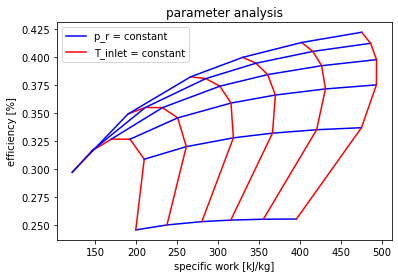

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# data import
df_eta = pd.read_csv('data/eta.csv', header=0, index_col=0)
df_swk = pd.read_csv('data/swk.csv', header=0, index_col=0)

# select values to plot
fig, eta_swk = plt.subplots()

for i in range(5):
    eta_swk.plot(df_swk.iloc[:,i], df_eta.iloc[:,i], color='blue')
    eta_swk.plot(df_swk.iloc[i], df_eta.iloc[i], color='red')

eta_swk.plot(df_swk.iloc[:,5],df_eta.iloc[:,5], color='blue', label='p_r = constant')
eta_swk.plot(df_swk.iloc[5], df_eta.iloc[5], color='red', label='T_inlet = constant')

# legend
eta_swk.set(xlabel='specific work [kJ/kg]', ylabel='efficiency [%]', title='parameter analysis')

# final plot
plt.legend()
plt.show()